In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype

def one_hot_encode_columns(df, columns):
    """
    One-hot encode specified columns in a DataFrame.

    :param df: The DataFrame to process.
    :param columns: A list of column names to be one-hot encoded.
    :return: The modified DataFrame and a list of new column indices.
    """
    original_columns = set(df.columns)
    for column in columns:
        encoded = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, encoded], axis=1).drop(column, axis=1)
    new_columns = set(df.columns) - original_columns
    new_column_indices = [df.columns.get_loc(c) for c in new_columns]
    return df, new_column_indices

def scale_columns(df, scaler, columns):
    """
    Scale specified columns using the provided scaler.

    :param df: The DataFrame to process.
    :param scaler: Scaler instance (e.g., MinMaxScaler).
    :param columns: A list of column names to be scaled.
    :return: The modified DataFrame.
    """
    df[columns] = scaler.fit_transform(df[columns])
    return df

def most_common_ratio(series):
    """
    Calculate the ratio of the most common value in a Series.

    :param series: Pandas Series to analyze.
    :return: Ratio of the most common value.
    """
    return series.value_counts(normalize=True).iloc[0]

def remove_column_with_high_ratio(df, exclude_columns):
    """
    Remove columns with a high ratio of a single value.

    :param df: The DataFrame to process.
    :param exclude_columns: A list of column names to be excluded from processing.
    :return: The modified DataFrame.
    """
    threshold = 0.98
    cols_to_drop = [col for col in df.columns if most_common_ratio(df[col]) > threshold and col not in exclude_columns]
    return df.drop(columns=cols_to_drop)

def creating_indicator_variables(df):
    """
    Create indicator variables for columns with missing values.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    indicator_dict = {}
    for col in df.columns:
        if df[col].isna().any():
            indicator_col_name = f"{col}_present"
            indicator_dict[indicator_col_name] = df[col].notna().astype(int)
    indicator_df = pd.DataFrame(indicator_dict)
    return pd.concat([df, indicator_df], axis=1)

def custom_imputation(df):
    """
    Apply custom imputation to DataFrame columns based on the percentage of missing values.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    for col in df.columns:
        if df[col].isna().mean() > 0.40:
            df[col].fillna(0, inplace=True)
        elif is_numeric_dtype(df[col]):
            df[col].fillna(df[col].median(), inplace=True)
    return df

def remove_highly_correlated_column(df, exclude_columns):
    """
    Remove highly correlated columns from the DataFrame.

    :param df: The DataFrame to process.
    :param exclude_columns: A list of column names to be excluded from processing.
    :return: The modified DataFrame.
    """
    threshold = 0.99
    corr_matrix = df.drop(columns=exclude_columns).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold) and column not in exclude_columns]
    return df.drop(columns=to_drop)

def remove_column_with_zero_variance(df):
    """
    Remove columns with zero variance from the DataFrame.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    return df.loc[:, df.var() != 0]

def ensure_column_are_numeric(df):
    """
    Ensure all columns in the DataFrame are of numeric type.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    for col in df.columns:
        if not is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def impute_with_median(df):
    """
    Impute missing values in the DataFrame with the median.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    non_empty_columns = df.columns[df.notna().any()].tolist()
    imputer = SimpleImputer(strategy='median')
    df = imputer.fit_transform(df)
    return pd.DataFrame(df, columns=non_empty_columns)

def impute_with_mean(df):
    """
    Impute missing values in the DataFrame with the median.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    non_empty_columns = df.columns[df.notna().any()].tolist()
    imputer = SimpleImputer(strategy='mean')
    df = imputer.fit_transform(df)
    return pd.DataFrame(df, columns=non_empty_columns)

def impute_with_zero(df):
    """
    Impute missing values in the DataFrame with the median.

    :param df: The DataFrame to process.
    :return: The modified DataFrame.
    """
    non_empty_columns = df.columns[df.notna().any()].tolist()
    df = df[non_empty_columns]
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    df = imputer.fit_transform(df)
    return pd.DataFrame(df, columns=non_empty_columns)

def determine_columns_to_scale(df, columns_to_one_hot_encode):
    """
    Determine which columns in the DataFrame should be scaled.

    :param df: The DataFrame to process.
    :param columns_to_one_hot_encode: A list of column names that should not be scaled.
    :return: A list of column names to be scaled.
    """
    all_columns = set(df.columns)
    non_scale_columns = set(columns_to_one_hot_encode)
    return list(all_columns - non_scale_columns)


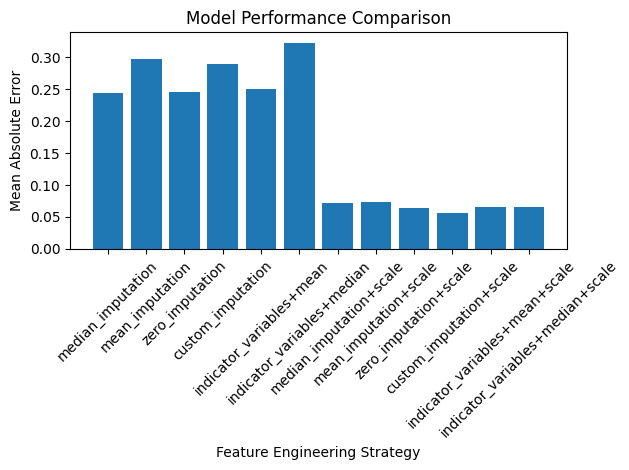

<Figure size 640x480 with 0 Axes>

In [33]:
!pip install xgboost
import pandas as pd
import xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

def load_data(file_path):
    return pd.read_csv(file_path, low_memory=False)

def feature_engineering(df, strategy):
    if strategy == 'median_imputation':
        df = impute_with_median(df)
    elif strategy == 'mean_imputation':
        df = impute_with_mean(df)
    elif strategy == 'zero_imputation':
        df = impute_with_zero(df)
    elif strategy == 'custom_imputation':
        df = custom_imputation(df)
    elif strategy == 'indicator_variables+mean':
        df = creating_indicator_variables(df)
        df = impute_with_mean(df)
    elif strategy == 'indicator_variables+median':
        df = creating_indicator_variables(df)
        df = impute_with_median(df)
    elif strategy == 'median_imputation+scale':
        df = impute_with_median(df)
        columns_to_scale = determine_columns_to_scale(df, columns_to_one_hot_encode) 
        scaler = MinMaxScaler()
        df = scale_columns(df, scaler, columns_to_scale)
    elif strategy == 'mean_imputation+scale':
        df = impute_with_mean(df)
        columns_to_scale = determine_columns_to_scale(df, columns_to_one_hot_encode) 
        scaler = MinMaxScaler()
        df = scale_columns(df, scaler, columns_to_scale)
    elif strategy == 'zero_imputation+scale':
        df = impute_with_zero(df)
        columns_to_scale = determine_columns_to_scale(df, columns_to_one_hot_encode) 
        scaler = MinMaxScaler()
        df = scale_columns(df, scaler, columns_to_scale)
    elif strategy == 'custom_imputation+scale':
        df = custom_imputation(df)
        columns_to_scale = determine_columns_to_scale(df, columns_to_one_hot_encode) 
        scaler = MinMaxScaler()
        df = scale_columns(df, scaler, columns_to_scale)
    elif strategy == 'indicator_variables+mean+scale':
        df = creating_indicator_variables(df)
        df = impute_with_mean(df)
        columns_to_scale = determine_columns_to_scale(df, columns_to_one_hot_encode) 
        scaler = MinMaxScaler()
        df = scale_columns(df, scaler, columns_to_scale)
    elif strategy == 'indicator_variables+median+scale':
        df = creating_indicator_variables(df)
        df = impute_with_median(df)
        columns_to_scale = determine_columns_to_scale(df, columns_to_one_hot_encode) 
        scaler = MinMaxScaler()
        df = scale_columns(df, scaler, columns_to_scale)
    
    df = ensure_column_are_numeric(df)
    return df

def train_and_evaluate(X_train, X_test, Y_train, Y_test):
    grid_search.fit(X_train, Y_train)
    Y_pred = grid_search.predict(X_test)
    return mean_absolute_error(Y_test, Y_pred)

def plot_mae_results(results):
    plt.bar(results.keys(), results.values())
    plt.xlabel('Feature Engineering Strategy')
    plt.ylabel('Mean Absolute Error')
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.savefig('mae_comparison.png')

# Initialize parameters and model
path = './Files/Before_Feature_Engineering/data_D.csv'
regression_columns_D = ['Ωx', 'Ωy', 'µx', 'µy', 'CMR', 'SSF', 'ACMR', 'IO-ln θ', 'IO-β', 'LS-ln θ', 'LS-β', 'CP-ln θ', 'CP-β']
target_columns = regression_columns_D
model = RandomForestRegressor()
parameters = {'n_estimators': [20]}
grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
columns_to_one_hot_encode = ["architectural_archetype", "stories", "soil_class", "seismic_zone", "connection_system"]
strategies = ['median_imputation', 'mean_imputation', 'zero_imputation', 'custom_imputation', 'indicator_variables+mean','indicator_variables+median',
             'median_imputation+scale', 'mean_imputation+scale', 'zero_imputation+scale', 'custom_imputation+scale', 'indicator_variables+mean+scale','indicator_variables+median+scale']

df = load_data(path)
df, _ = one_hot_encode_columns(df, columns_to_one_hot_encode)
performance_results = {}

for strategy in strategies:
    df_processed = feature_engineering(df.copy(), strategy)
    X_train, X_test, Y_train, Y_test = train_test_split(df_processed.drop(target_columns, axis=1), df_processed[target_columns], test_size=0.2)
    mae = train_and_evaluate(X_train, X_test, Y_train, Y_test)
    performance_results[strategy] = mae

plot_mae_results(performance_results)

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
import itertools

one_hot_columns = ["architectural_archetype", "stories", "soil_class", "seismic_zone", "connection_system"]
exclude_columns = ["connection_system_ATS", "connection_system_HD"]

def apply_preprocessing_techniques(df, techniques):
    """
    Apply various preprocessing techniques to the DataFrame.

    :param df: DataFrame to process.
    :param techniques: List of preprocessing techniques to apply.
    :return: Processed DataFrame.
    """
    for technique in techniques:
        if technique in strategy_functions:
            df = strategy_functions[technique](df)
    return df

def train_and_evaluate(model, parameters, X_train, X_test, Y_train, Y_test):
    """
    Train the model and evaluate its performance using MAE.

    :param model: The machine learning model.
    :param parameters: Hyperparameters for the model.
    :param X_train, X_test, Y_train, Y_test: Training and testing datasets.
    :return: Mean Absolute Error of the model.
    """
    grid_search = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, Y_train)
    Y_pred = grid_search.predict(X_test)
    return mean_absolute_error(Y_test, Y_pred)

def plot_mae_results(results):
    """
    Plot the Mean Absolute Error results in a sorted horizontal bar chart.

    :param results: Dictionary containing the feature engineering strategies and their MAEs.
    """
    plt.figure(figsize=(12, 8))

    # Sort the results for better visualization
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))

    # Create a horizontal bar chart
    plt.barh(list(sorted_results.keys()), list(sorted_results.values()), color='skyblue')
    plt.xlabel('Mean Absolute Error')
    plt.ylabel('Feature Engineering Strategy')
    plt.title('Model Performance Comparison')

    # Adjust layout to accommodate longer strategy names
    plt.tight_layout()

    # Save the plot before showing
    plt.savefig('mae_comparison_sorted.png')
    plt.show()



# Modify the strategy_functions to include lambda functions for techniques requiring additional parameters
strategy_functions = {
    'median': lambda df: impute_with_median(df),
    'mean': lambda df: impute_with_mean(df),
    'zero': lambda df: impute_with_zero(df),
    'custom': lambda df: custom_imputation(df),
    'indicator': lambda df: creating_indicator_variables(df),
    'scaling': lambda df: scale_columns(df, MinMaxScaler(), determine_columns_to_scale(df, one_hot_columns)),
    'correlation': lambda df: remove_highly_correlated_column(df, exclude_columns),
    'variance' : lambda df: remove_column_with_zero_variance(df),
    'ratio' : lambda df: remove_column_with_high_ratio(df, exclude_columns)
}




def main():
    path = './Files/Before_Feature_Engineering/data_D.csv'
    df = load_data(path)
    target_columns = ['Ωx', 'Ωy', 'µx', 'µy', 'CMR', 'SSF', 'ACMR', 'IO-ln θ', 'IO-β', 'LS-ln θ', 'LS-β', 'CP-ln θ', 'CP-β']

    model = RandomForestRegressor()
    parameters = {'n_estimators': [20]}
    df_encoded, _ = one_hot_encode_columns(df, one_hot_columns)

    # Define preprocessing strategies
    imputation_strategies = ['median', 'mean', 'zero', 'custom']
    other_strategies = ['indicator', 'scaling', 'correlation', 'variance', 'ratio']

    # Generate combinations
    all_combinations = []
    for imp_strategy in imputation_strategies:
        for r in range(len(other_strategies) + 1):
            for combo in itertools.combinations(other_strategies, r):
                all_combinations.append((imp_strategy,) + combo)

    performance_results = {}

    for techniques in all_combinations:
        X = df_encoded.drop(target_columns, axis=1)
        Y = df_encoded[target_columns]
        X = apply_preprocessing_techniques(X.copy(), techniques)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        mae = train_and_evaluate(model, parameters, X_train, X_test, Y_train, Y_test)
        performance_results[' + '.join(techniques)] = mae

    plot_mae_results(performance_results)

if __name__ == '__main__':
    main()


KeyboardInterrupt: 